# Keras pre-requiste libraries


In [0]:
#import keras pre-requiste libraries
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten , Reshape
from keras.models import Model
from keras import backend as K
import keras.layers
import keras as Kr
from keras.models import model_from_json

# Mounting drive 

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#checking file loaded in drive 
!ls 

sample_data


# Encoder

In [0]:
#Defining input for encoder model

In [0]:
input_img = Input(shape=(28, 28, 1))

In [0]:
#Encoder layers

In [0]:
x1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x2 = MaxPooling2D((2, 2), padding='same')(x1)
x3 = Conv2D(8, (3, 3), activation='relu', padding='same')(x2)
x4 = MaxPooling2D((2, 2), padding='same')(x3)
x5 = Conv2D(8, (3, 3), activation='relu', padding='same')(x4)
x6 = MaxPooling2D((2, 2), padding='same')(x5)
encoded = Flatten()(x6)

#defining model for encoder
Encoder = Model(input_img,encoded)

# Decoder

In [0]:
#Defining input for decoder model
encoded_shape =Input(shape=(None,))

In [0]:
#Decoder layers

x5 = Reshape((4,4,8,))(encoded_shape)
x6 = Conv2D(8, (3, 3), activation='relu', padding='same')(x5)
x7 = UpSampling2D((2, 2))(x6)
x8 = Conv2D(8, (3, 3), activation='relu', padding='same')(x7)
x9 = UpSampling2D((2, 2))(x8)
x10 = Conv2D(16, (3, 3), activation='relu')(x9)
x11 = UpSampling2D((2, 2))(x10)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x11)

#defining model for decoder
Decoder = Model(encoded_shape,decoded)

In [0]:
#combining encoder and decoder model 
outputs = Decoder(Encoder(input_img))
#defined autoencoder model as combined model of encoder and decoder
autoencoder = Model(input_img, outputs, name='vae_mlp')

# Dataset

In [0]:
#loading MNISt dataset
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# Training our Model

In [0]:
#Before training our model we need to compile our model
#Using optimizer as adadelta and loss function as binary cross entropy
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
#pringting model summary to check model is combined properly 
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 128)               1904      
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         2481      
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [0]:
#model fit
#training for 2 epoch u can try different epoch number
autoencoder.fit(x_train, x_train,
                epochs=2,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 98s 2ms/step - loss: 0.2072 - val_loss: 0.1572
Epoch 2/2
60000/60000 [==============================] - 96s 2ms/step - loss: 0.1485 - val_loss: 0.1422


# Saving Model

In [0]:
#saving combined model autoencoder
# serialize autoencoder model to JSON
autoencoder_json = autoencoder.to_json()
with open("autoencoder.json", "w") as json_file:
    json_file.write(autoencoder_json)
# serialize weights to HDF5
autoencoder.save_weights("autoencoder_model.h5")
print("Saved autoencoder model to disk")

Saved autoencoder model to disk


In [0]:
#saving encoder model
# serialize encoder model to JSON
model_json = Encoder.to_json()
with open("Encoder.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
Encoder.save_weights("Encoder_model.h5")
print("Saved encoder model to disk")

Saved encoder model to disk


In [0]:
#saving decoder model
# serialize decoder model to JSON
model1_json = Decoder.to_json()
with open("Decoder.json", "w") as json_file:
    json_file.write(model1_json)
# serialize weights to HDF5
Decoder.save_weights("Decoder_model.h5")
print("Saved decoder model to disk")

Saved decoder model to disk


# Loading Model

In [0]:
#loading encoder model
# load encoder json and create model
json_file = open('Encoder.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
Encoder_loaded_model = model_from_json(loaded_model_json)
# load weights into new model
Encoder_loaded_model.load_weights("Encoder_model.h5")
print("Loaded encoder model from disk")

Loaded encoder model from disk


In [0]:
#loading decoder model
#load decoder json and create model
json_file_dec = open('Decoder.json','r')
json = json_file_dec.read()
json_file_dec.close()
Decoder_loaded_model =model_from_json(json)
#load weightsa into new model
Decoder_loaded_model.load_weights("Decoder_model.h5")

print "Decoder model loaded successfully"

Decoder model loaded successfully


In [0]:
#loading combined model autoencoder
#load decoder json and create model
autoencoder_jsonfile = open('autoencoder.json','r')
json = autoencoder_jsonfile.read()
autoencoder_jsonfile.close()
autoencoder_loaded_model =model_from_json(json)
#load weightsa into new model
autoencoder_loaded_model.load_weights("autoencoder_model.h5")

print "autoencoder model loaded successfully"

autoencoder model loaded successfully


# Testing our Model

autoencoder model

In [0]:
#Before testing our combined model we need to compile oure model for optimize purpose

autoencoder_loaded_model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
#testing our test data by passing to autoencoder model
decoded_img = autoencoder_loaded_model.predict(x_test)

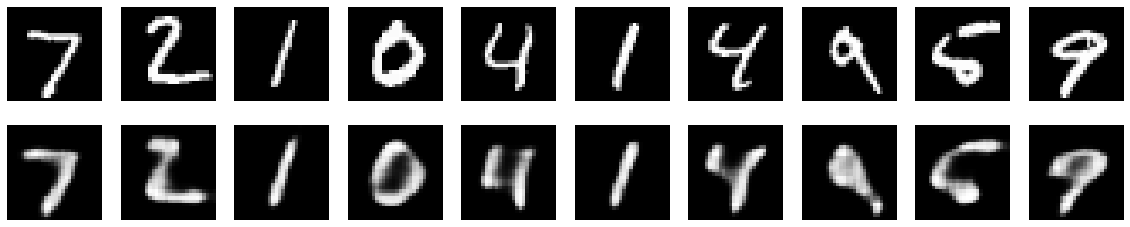

In [0]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Encoder model

In [0]:
#Encoder model compile
Encoder_loaded_model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
#Decoder model compile
Decoder_loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
#testing with test data
encoded_output = Encoder_loaded_model.predict(x_test)

In [0]:
#giving encoded output to input of decoder model
decoded_output = Decoder_loaded_model.predict(encoded_output)

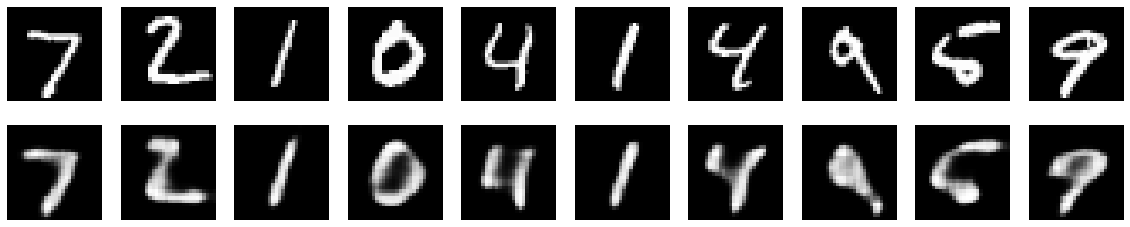

In [0]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_output[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Testing our model with random vector

In [0]:
#generating random gaussian 
import numpy as np
image_vect = np.random.normal(0,1,size=(10,128,))

In [0]:
#using decoder model to test our model
decoded_output = Decoder_loaded_model.predict(image_vect)

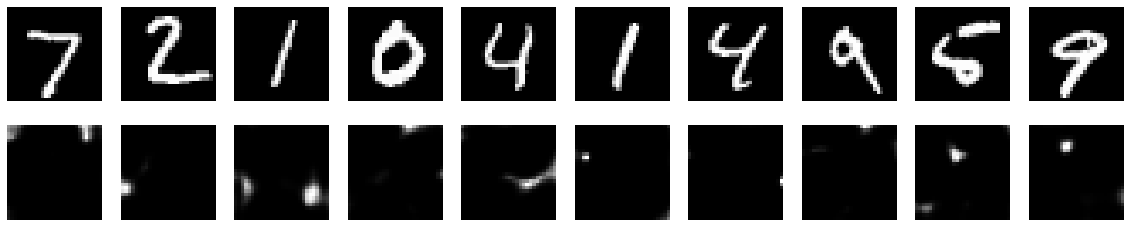

In [0]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_output[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()